## Unsupervised MNIST: denoising

### Variational autoencoder

##### and an exploration of a sparse matrix format in PyTorch

Stephen Fleming, 20190323

In [1]:
USE_CUDA = False

__Problem Statement__

There are MNIST images of hand-written digits.  There is structured noise added to each image (drawn randomly from the same underlying noise distribution).  The idea is to remove that structured noise.  Some of the images are just noise, with no digit.  The goal is also to identify the images which have no digit present.

A secondary aim of this notebook explores the use of a sparse data structure to hold datasets like this in memory.

__The Dataset__

The typical MNIST dataset is used to create a new sparse dataset.  Rows are images, columns are 784 pixels, and the pixels are sparse entries.

Images are scaled arbitrarily (by scale factors drawn from a LogNormal distribution) and structured noise is added (same set of pixels, same ratios, with different scaling, drawn from a smaller LogNormal).  This dataset is meant to be a visual analog of the scRNA-seq data denoising problem.

The idea is to use sparse torch tensors to load the entire dataset into memory at once, removing the need for repeated loading from disk (and repeated transfers to GPU if using CUDA).

__The generative model__

For a latent variable $z \in \mathbb{R}^q$, and observed data $x \in \mathbb{R}^d$ with $q < d$,

$$ z \sim \mathcal{N} (\mathbb{0}, \mathbb{1}) $$
$$ \chi = f_d(z) $$
$$ y \sim \text{Bernoulli} (p_y) $$
$$ d \sim \text{LogNormal} (d_\mu, d_\sigma) $$
$$ d^a \sim \text{LogNormal} (d^a_\mu, d^a_\sigma) $$
$$ x \sim \text{Poisson} (y d \chi + d^a \chi^a_{\text{noise}}) $$

__The variational posterior__

Given $x_i$, we would like a way to come up with $z_i$.  We could either memorize a new $z_i$ for each datapoint $i$, or we can _amortize_ our inference procedure by learning a mapping from $x$ to $z$.  We will do the latter.  Call that function $f_e(x)$.  Then our variational posterior for $p(z|x)$ is as follows:

$$ z_\mu, z_\sigma = f_e(x) $$
$$ z | x \sim \mathcal{N} (z_\mu, z_\sigma) $$
$$ p_y = f_{e,p}(x) $$
$$ d = \max \left( 0, \sum x - d^a_\mu \right) $$

In [2]:
import pyro
from pyro.optim import ClippedAdam
import pyro.distributions as dist
from pyro.infer import SVI, JitTraceEnum_ELBO, config_enumerate

pyro.enable_validation(True)

import torch
import torch.nn as nn
from torch.distributions import constraints
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Initial MNIST dataset

input shape: torch.Size([512, 1, 28, 28])
output shape: torch.Size([512])


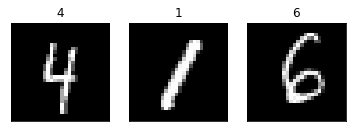

In [3]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = datasets.MNIST(root=root, train=True, transform=trans,
                               download=download)
    test_set = datasets.MNIST(root=root, train=False, transform=trans)

#     kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    kwargs = {'num_workers': 0, 'pin_memory': False}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

train_loader, test_loader = setup_data_loaders(batch_size=512, use_cuda=USE_CUDA)

# check out data loading to see what we get

for data in train_loader:
    print(f'input shape: {data[0].shape}')
    print(f'output shape: {data[1].shape}')
    plt.figure()
    for i in range(min(3, data[1].shape[0])):
        plt.subplot(1, 3, i+1)
        plt.imshow(data[0][i, ...].numpy().squeeze(), cmap='gray')
        plt.title(data[1][i].item())
        plt.xticks([])
        plt.yticks([])
    plt.show()
    break

#### Creation of sparse dataset with added noise

In [4]:
# estimate of nonzero entries in sparse matrix that could hold the whole dataset

60000*200000/512

23437500.0

In [5]:
data[0].max()

tensor(1.)

In [6]:
data[0].reshape([-1, data[0].shape[-1] * data[0].shape[-2]]).shape

torch.Size([512, 784])

In [7]:
# figure out the noise profile

NOISE_SCALE = 6.0
SIGNAL_SCALE = 8.0

print(f'scale of noise/signal is about {np.exp(NOISE_SCALE) / np.exp(SIGNAL_SCALE):.2g}')

# use the average of some of the data...
average = data[0].reshape([-1, data[0].shape[-1] * data[0].shape[-2]]).mean(dim=0)
average = average / average.sum(dim=-1, keepdim=True)

scale of noise/signal is about 0.14


In [8]:
average.shape

torch.Size([784])

In [9]:
# go through training dataset until we've got about 10k

NUM_IMAGES = 30000
NUM_EMPTY = 30000

rows = []
cols = []
vals = []

rows_true = []
cols_true = []
vals_true = []

batch = 0

for batch, data in enumerate(train_loader):
    
    # draw scale factors for signal
    d = dist.LogNormal(SIGNAL_SCALE, 0.2).expand([data[0].shape[0]]).sample()
    
    # draw scale factors for noise
    da = dist.LogNormal(NOISE_SCALE, 0.2).expand([data[0].shape[0]]).sample()
    
    reshaped_data = data[0].reshape([-1, data[0].shape[-1] * data[0].shape[-2]])
    reshaped_data = reshaped_data / reshaped_data.sum(dim=-1, keepdim=True)
    
    # create dataset
    true_data = (reshaped_data * d.unsqueeze(-1)).round()
    
    # to sparse format
    ind_tensor_true = torch.nonzero(true_data)
    nzrows_true = ind_tensor_true[:, 0]
    nzcols_true = ind_tensor_true[:, 1]
    rows_true.extend((nzrows_true + batch * train_loader.batch_size).tolist())
    cols_true.extend(nzcols_true.tolist())
    vals_true.extend(true_data[nzrows_true, nzcols_true].tolist())
    
    # create noisy dataset
    noisy_data = true_data + (average.unsqueeze(0) * da.unsqueeze(-1)).round()
    
    ind_tensor = torch.nonzero(noisy_data)
    nzrows = ind_tensor[:, 0]
    nzcols = ind_tensor[:, 1]
    rows.extend((nzrows + batch * train_loader.batch_size).tolist())
    cols.extend(nzcols.tolist())
    vals.extend(noisy_data[nzrows, nzcols].tolist())
    
    if (batch + 1) * train_loader.batch_size > NUM_IMAGES:
        break

# add in more images that are noise alone

num_im = rows[-1]

for i in range(int(NUM_EMPTY/500)):
    
    # draw scale factors for noise
    da = dist.LogNormal(NOISE_SCALE, 0.2).expand([500]).sample()
    
    noisy_data = (average.unsqueeze(0) * da.unsqueeze(-1)).round()
    
    ind_tensor = torch.nonzero(noisy_data)
    nzrows = ind_tensor[:, 0]
    nzcols = ind_tensor[:, 1]
    rows.extend((num_im + i * 500 + nzrows).tolist())
    cols.extend(nzcols.tolist())
    vals.extend(noisy_data[nzrows, nzcols].tolist())

In [10]:
# make sparse tensors

sparse_data = torch.sparse.FloatTensor(torch.LongTensor([rows, cols]), 
                                       torch.tensor(vals), 
                                       torch.Size([rows[-1] + 1, 28 * 28]))

sparse_truth = torch.sparse.FloatTensor(torch.LongTensor([rows_true, cols_true]), 
                                        torch.tensor(vals_true),
                                        torch.Size([rows_true[-1] + 1, 28 * 28]))

In [11]:
sparse_data

tensor(indices=tensor([[    0,     0,     0,  ..., 60206, 60206, 60206],
                       [  125,   126,   127,  ...,   684,   685,   686]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(60207, 784), nnz=17268831, layout=torch.sparse_coo)

In [12]:
sparse_truth

tensor(indices=tensor([[    0,     0,     0,  ..., 30207, 30207, 30207],
                       [  148,   149,   150,  ...,   683,   684,   685]]),
       values=tensor([ 6., 16., 34.,  ..., 23., 15.,  1.]),
       size=(30208, 784), nnz=4459527, layout=torch.sparse_coo)

In [13]:
from typing import List, Union

def sparse_collate(sparse_tensor: torch.sparse.FloatTensor, 
                   row_inds: Union[int, List[int]]) -> torch.FloatTensor:
    """Row slice a sparse torch tensor, one row at a time.
    Return dense tensor.
    """
    
    if type(row_inds) is int:
        row_inds = [row_inds]
    
    # find all elements with given row ind
    logic = torch.zeros(sparse_tensor._values().shape).byte()  # false
    for ind in row_inds:
        logic = logic | sparse_tensor._indices()[0, :].eq(ind)
    
    i = torch.nonzero(logic).squeeze()
    
    # new sparse tensor
    inds = sparse_tensor._indices()[:, i]
    _, rows = torch.unique(inds[0, :], return_inverse=True)
    inds[0, :] = rows
    s = torch.sparse.FloatTensor(inds,
                                 sparse_tensor._values()[i],
                                 torch.Size([len(row_inds), 28 * 28]))
    
    return s.to_dense()

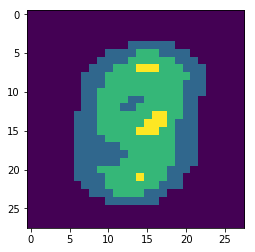

In [14]:
plt.imshow((average * da[0].unsqueeze(-1)).round().reshape([28, 28]))
plt.show()

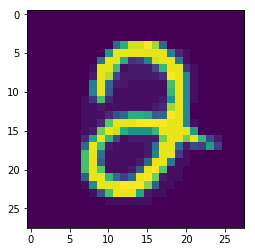

In [15]:
plt.imshow(sparse_collate(sparse_data, 1000).reshape([28, 28]))
plt.show()

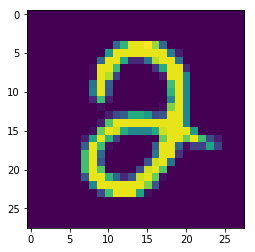

In [16]:
plt.imshow(sparse_collate(sparse_truth, 1000).reshape([28, 28]))
plt.show()

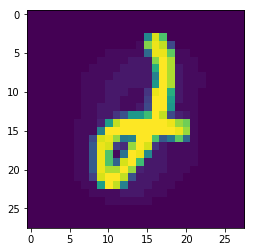

In [17]:
plt.imshow(sparse_collate(sparse_data, 25000).reshape([28, 28]))
plt.show()

#### Define the encoder and decoder: use nn.Linear()

In [18]:
class Encoder(nn.Module):
    """A basic encoder with a single hidden layer.
    
    Encodes two parameters, 'loc' and 'scale', which are the 
    mean and standard deviation of a Gaussian in latent space.
    The 'scale' is made to be positive by applying torch.exp().
    
    """
    
    def __init__(self, d: int, h: int, q: int):
        super(Encoder, self).__init__()
        assert q < d, f"Latent space ({q}) must have smaller dimension that data ({d})."
        self.d = d
        self.q = q
        self.h = h
        self.fc1 = nn.Linear(d, h)
        self.fc_mu = nn.Linear(h, q)
        self.fc_sigma = nn.Linear(h, q)
        self.softplus = nn.Softplus()
        
    def forward(self, x):
        x = x / x.sum(dim=-1, keepdim=True)  # normalize
        hidden = self.softplus(self.fc1(x))
        return {'loc': self.fc_mu(hidden), 
                'scale': torch.exp(self.fc_sigma(hidden))}

In [19]:
class EncoderP(nn.Module):
    """A basic encoder with no hidden layer.
    
    Encodes one parameter, the logit of a Bernoulli.
    
    """
    
    def __init__(self, d: int, q: int, transition_estimate: int):
        super(EncoderP, self).__init__()
        assert q < d, f"Latent space ({q}) must have smaller dimension that data ({d})."
        self.d = d
        self.q = q
        self.transition_estimate = transition_estimate
        self.fc1 = nn.Linear(d + 1, q)
        with torch.no_grad():
            self.fc1.weight[0, 0] = 1.0
        
    def forward(self, x):
        total = x.sum(dim=-1, keepdim=True)
        return self.fc1(torch.cat((total, x), dim=-1)) - self.transition_estimate

In [20]:
class Decoder(nn.Module):
    """A basic decoder with a single hidden layer.
    
    Output is on a simplex.
    
    """
    
    def __init__(self, q: int, h: int, d: int):
        super(Decoder, self).__init__()
        assert q < d, f"Latent space ({q}) must have smaller dimension that data ({d})."
        self.d = d
        self.q = q
        self.h = h
        self.fc1 = nn.Linear(q, h)
        self.fc2 = nn.Linear(h, d)
        self.softplus = nn.Softplus()
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        return self.softmax(self.fc2(self.softplus(self.fc1(x))))

#### Define the Pyro model and guide

In [21]:
class Denoiser(nn.Module):
    """Pyro model based on a variational autoencoder.
    
    Attributes:
        encoder: pytorch nn.Module instance of an Encoder for p(z|x).
        decoder: pytorch nn.Module instance of a Decoder for p(x|z).
        use_cuda: True to use a GPU.
    
    """
    
    def __init__(self, 
                 encoder: Encoder, 
                 encoderP: EncoderP, 
                 decoder: Decoder, 
                 chi_noise_init: torch.FloatTensor, 
                 use_cuda: bool = True):
        super(Denoiser, self).__init__()
        self.encoder = encoder
        self.encoderP = encoderP
        self.decoder = decoder
        
        self.noise_loc_prior = NOISE_SCALE
        self.signal_loc_prior = SIGNAL_SCALE
        self.p_y_prior = NUM_IMAGES / (NUM_IMAGES + NUM_EMPTY)
        self.chi_noise_init = chi_noise_init
        
        self.q = encoder.q
        self.d = encoder.d
        assert encoder.fc_mu.out_features == decoder.fc1.in_features, \
            f"Latent space do not match for encoder ({encoder.fc_mu.out_features}) " \
            f"and decoder ({decoder.fc1.in_features})"
        assert encoder.fc1.in_features == decoder.fc2.out_features, \
            f"Data dimensions do not match for encoder ({encoder.fc1.in_features}) " \
            f"and decoder ({decoder.fc2.out_features})"
        self.use_cuda = use_cuda and torch.cuda.is_available()
        self.device = 'cuda' if self.use_cuda else 'cpu'
        if self.use_cuda:
            self.cuda()  # puts the encoder and decoder params on GPU
    
    def model(self, x):
        """Model for data generation."""
        
        # Register the decoder module with pyro
        pyro.module("decoder", self.decoder)
        
        # A noise parameter
        chi_noise = pyro.param("chi_noise", 
                               self.chi_noise_init.to(device=self.device),
                               constraint=constraints.simplex)
        
        # Plate structure implies conditional independence of data points
        # in a batch
        with pyro.plate("data", size=x.shape[0]):
            
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.q)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.q)))
            
            # Draw z from the prior p(z)
            z = pyro.sample("z", dist.Normal(loc=z_loc, 
                                             scale=z_scale).to_event(1))
            
            # Decode to get fractional image
            chi = self.decoder(z)
            
            # Draw scale factors
            d = pyro.sample("d", dist.LogNormal(loc=self.signal_loc_prior,
                                                scale=0.2))
            da = pyro.sample("da", dist.LogNormal(loc=self.noise_loc_prior,
                                                  scale=0.2))
            
            # Draw y for whether image contains a digit
            y = pyro.sample("y", dist.Bernoulli(self.p_y_prior))
            
            # Total image
            mu = (y.unsqueeze(-1) * d.unsqueeze(-1) * chi 
                  + da.unsqueeze(-1) * chi_noise) + 1e-10
            
            # Draw x according to our model for p(x|z)
            pyro.sample("obs", dist.Poisson(mu).to_event(1), obs=x)
    
    @config_enumerate(default='parallel')
    def guide(self, x):
        """Guide: the inference network."""
        
        # Register the encoder module with pyro
        pyro.module("encoder", self.encoder)
        pyro.module("encoderP", self.encoderP)
        
        # A noise scale parameter
        da_loc = pyro.param("da_loc", 
                            torch.tensor(self.noise_loc_prior)
                            .to(device=self.device),
                            constraint=constraints.positive)
        
        # Send the data through the encoders
        enc = self.encoder(x)
        p_y = self.encoderP(x).squeeze()
        
        # Inference of the latent embedding from the data:
        with pyro.plate("data", size=x.shape[0]):
            
            # Draw scale factors
            da = pyro.sample("da", dist.LogNormal(loc=da_loc,
                                                  scale=0.05))
            
            d_mu_estimate = (x.sum(dim=-1, keepdim=False) - da)
            d_mu_estimate = torch.clamp(d_mu_estimate, min=0.).log1p()
            
            d = pyro.sample("d", dist.LogNormal(loc=d_mu_estimate,
                                                scale=0.2))
            
            masking = dist.Bernoulli(logits=p_y).sample().squeeze()
            
            # Sample z from p(z|x)
            z = pyro.sample("z", dist.Normal(loc=enc['loc'],
                                             scale=enc['scale'])
                            .to_event(1).mask(masking))
            
            # Draw y for whether image contains a digit
            y = pyro.sample("y", dist.Bernoulli(logits=p_y))

In [22]:
# setting up the model

Q = 20  # dimensionality of our latent embedding

D = 28*28
assert Q < D, "The embedded dimension must be less than that of the data."

encoder = Encoder(d=D, h=100, q=Q)
encoderP = EncoderP(d=D, q=1, transition_estimate=np.mean([np.exp(NOISE_SCALE), np.exp(SIGNAL_SCALE)]))
decoder = Decoder(q=Q, h=100, d=D)

denoiser = Denoiser(encoder, encoderP, decoder, average, use_cuda=USE_CUDA)

In [23]:
denoiser

Denoiser(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=100, bias=True)
    (fc_mu): Linear(in_features=100, out_features=20, bias=True)
    (fc_sigma): Linear(in_features=100, out_features=20, bias=True)
    (softplus): Softplus(beta=1, threshold=20)
  )
  (encoderP): EncoderP(
    (fc1): Linear(in_features=785, out_features=1, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=20, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=784, bias=True)
    (softplus): Softplus(beta=1, threshold=20)
    (softmax): Softmax()
  )
)

In [24]:
# set up data loading from sparse tensor

class SparseDataLoader:
    """If the sparse dataset is already on GPU, it stays there."""

    def __init__(self,
                 dataset: torch.sparse.FloatTensor,
                 batch_size: int = 512,
                 shuffle: bool = True):
        self.dataset = dataset
        self.ind_list = np.arange(self.dataset.shape[0])
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.row_slice = {}
        self._index()
        self._reset()

    def _reset(self):
        if self.shuffle:
            np.random.shuffle(self.ind_list)  # Shuffle these cell inds in place
        self.ptr = 0
    
    def _index(self):
        # index the rows for faster row slicing using a hash table
        
        # first sort coo elements by row
        order = np.argsort(self.dataset._indices()[0, :].cpu().numpy())
        self.dataset = torch.sparse.FloatTensor(self.dataset._indices()[:, order],
                                                self.dataset._values()[order],
                                                self.dataset.shape)
        
        # initialize dict
        self.row_slice = dict([(r, np.empty(2, dtype=int)) for r in range(self.dataset.shape[0])])
        
        ptr = 0
        rows = self.dataset._indices()[0, :].cpu().numpy()
        row_increment_locs = np.where(rows[1:] - rows[:-1] > 0)[0]
        
        # first row always has start at index 0
        self.row_slice[rows[0]][0] = 0
        
        # for every row increment location, record what ended and what started
        # want to be able to index by d[self.row_slice[row_ind][0]:self.row_slice[row_ind][1]]
        for loc in row_increment_locs:
            
            # which row ended there
            self.row_slice[rows[loc]][1] = loc + 1
            
            # which row starts next
            self.row_slice[rows[loc + 1]][0] = loc + 1
            
        # last row always ends at the end
        self.row_slice[rows[-1]][1] = rows.size
    
    def _collate(self, row_inds: np.ndarray) -> torch.FloatTensor:
        """Row slice a sparse torch tensor and return a dense tensor."""
        
        # create the zero-filled tensor
#         dense_tensor = torch.cuda.FloatTensor(1000, 1000).fill_(0)  # on GPU directly
        dense_tensor = torch.zeros([row_inds.size, 
                                    self.dataset.shape[1]]).to(device=self.dataset.device)

        # fill in nonzero elements one row at a time
        for new_ind, ind in enumerate(row_inds):
            dense_tensor[new_ind, 
                         self.dataset._indices()[1, self.row_slice[ind][0]:self.row_slice[ind][1]]] = \
                self.dataset._values()[self.row_slice[ind][0]:self.row_slice[ind][1]]
        
        return dense_tensor
        
#         # slower:
        
#         # get a torch tensor array of coo entry indices
#         slice_inds = tuple()
#         for ind in row_inds:
#             slice_inds.append(self.row_slice[ind])
#         slice_inds = torch.cat(slice_inds)
        
#         i = self.dataset._indices()[:, slice_inds]  # inds from dataset
#         _, rows = torch.unique(i[0, :], return_inverse=True)  # re-indexing rows
#         i[0, :] = rows  # rows are now 0:batch_size
        
#         return torch.sparse.FloatTensor(i,
#                                         self.dataset._values()[slice_inds],
#                                         torch.Size([row_inds.size, 
#                                                     self.dataset.shape[1]])).to_dense()

    def __len__(self):
        return int(self.ind_list.size)

    def __iter__(self):
        return self

    def __next__(self):
        if self.ptr == self.ind_list.size:
            self._reset()
            raise StopIteration()

        else:

            # Move the pointer by the number of cells in this minibatch.
            next_ptr = min(self.ind_list.size, self.ptr + self.batch_size)

            # Decide on cell (+ transition region) indices.
            inds = self.ind_list[self.ptr:next_ptr]

            # Get a dense tensor from the sparse matrix.
            dense_tensor = self._collate(inds)

            # Increment the pointer and return the minibatch.
            self.ptr = next_ptr
            return dense_tensor

In [25]:
train_loader = SparseDataLoader(sparse_data, batch_size=512, shuffle=True)

In [26]:
train_loader.row_slice[0]

array([  0, 306])

In [27]:
train_loader.dataset._indices()[:, train_loader.row_slice[0][0]:train_loader.row_slice[0][1]].shape

torch.Size([2, 306])

In [28]:
%%time

for d in train_loader:
    pass

CPU times: user 870 ms, sys: 5.25 ms, total: 875 ms
Wall time: 875 ms


In [29]:
d.shape

torch.Size([303, 784])

In [30]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

# def evaluate(svi, test_loader, use_cuda=False):
#     # initialize loss accumulator
#     test_loss = 0.
#     # compute the loss over the entire test set
#     for x in test_loader:
#         # if on GPU put mini-batch into CUDA memory
#         if use_cuda:
#             x = x.cuda()
#         # compute ELBO estimate and accumulate loss
#         test_loss += svi.evaluate_loss(x)
#     normalizer_test = len(test_loader.dataset)
#     total_epoch_loss_test = test_loss / normalizer_test
#     return total_epoch_loss_test

In [31]:
# start with a clean slate

pyro.clear_param_store()
train_loader._reset()

# setting up inference

optimizer = ClippedAdam({"lr": 1.0e-3})

svi = SVI(denoiser.model, 
          denoiser.guide, 
          optimizer, 
          loss=JitTraceEnum_ELBO())

train_elbo = []
test_elbo = []

In [32]:
# run

NUM_EPOCHS = 150
# TEST_FREQUENCY = 5

# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

#     if epoch % TEST_FREQUENCY == 0:
#         # report test diagnostics
#         total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
#         test_elbo.append(-total_epoch_loss_test)
#         print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/anaconda3/lib/python3.6/site-packages/pyro/distributions/util.py:96: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif reversed_shape[i] == 1 and not strict:
/anaconda3/lib/python3.6/site-packages/pyro/distributions/util.py:98: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a cons

[epoch 000]  average training loss: 2050.4907
[epoch 001]  average training loss: 1854.1300
[epoch 002]  average training loss: 1719.3957
[epoch 003]  average training loss: 1688.3624
[epoch 004]  average training loss: 1643.4103
[epoch 005]  average training loss: 1555.1400
[epoch 006]  average training loss: 1519.0066
[epoch 007]  average training loss: 1494.2616
[epoch 008]  average training loss: 1443.3833
[epoch 009]  average training loss: 1394.0200
[epoch 010]  average training loss: 1373.2511
[epoch 011]  average training loss: 1357.1384
[epoch 012]  average training loss: 1341.5663
[epoch 013]  average training loss: 1324.0990
[epoch 014]  average training loss: 1301.6976
[epoch 015]  average training loss: 1281.3088
[epoch 016]  average training loss: 1264.7021
[epoch 017]  average training loss: 1250.4065
[epoch 018]  average training loss: 1238.8709
[epoch 019]  average training loss: 1227.9369
[epoch 020]  average training loss: 1216.1659
[epoch 021]  average training loss

Make a dict to do fast lookup of indices for row slicing... ?  

Sped things up by a factor of about 600.

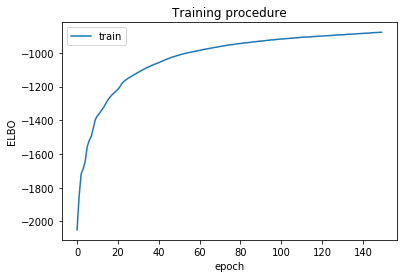

In [33]:
plt.plot(np.arange(0, len(train_elbo)), np.array(train_elbo))
# plt.plot(np.arange(0, len(train_elbo), TEST_FREQUENCY), np.array(test_elbo), '.--')
plt.xlabel('epoch')
plt.ylabel('ELBO')
plt.title('Training procedure')
plt.legend(['train', 'test'])
plt.show()

#### Explore the latent embedding

In [34]:
# examine the embedding...

# compute the embedding

z = np.empty([1, Q])
labels = np.empty(1)

for data in train_loader:
    if z.shape[0] >= 3000:
        break
    z = np.concatenate((z, denoiser.encoder(data.to(device=denoiser.device))['loc']
                        .detach().cpu().numpy()))
#     labels = np.concatenate((labels, data[1].numpy()))

z[np.isnan(z)] = 0
z[z > 1e100] = 1e100

In [35]:
# plot it

from sklearn.manifold import TSNE

z_tsne = TSNE(n_components=2, perplexity=100.).fit_transform(z)

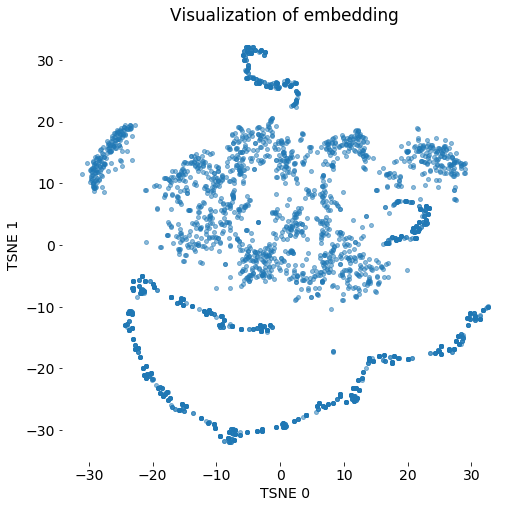

In [36]:
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(8, 8), frameon=False)
# for k in np.unique(labels):
#     plt.plot(z_tsne[labels==k, 0], 
#              z_tsne[labels==k, 1], '.', ms=8, alpha=0.5)
plt.plot(z_tsne[:, 0], 
         z_tsne[:, 1], '.', ms=8, alpha=0.5)

# lgnd = plt.legend(np.unique(labels).astype(int), 
#                   loc='center left', bbox_to_anchor=(1, 0.5))
# for i in range(len(lgnd.legendHandles)):
#     lgnd.legendHandles[i]._legmarker.set_markersize(20)
#     lgnd.legendHandles[i]._legmarker.set_alpha(1)

plt.xlabel('TSNE 0')
plt.ylabel('TSNE 1')
plt.title('Visualization of embedding')
plt.box(on=None)
plt.show()

In [37]:
from umap import UMAP

z_umap = UMAP(n_components=2).fit_transform(z)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 33 separate connected components using meta-embedding (experimental)
  n_components


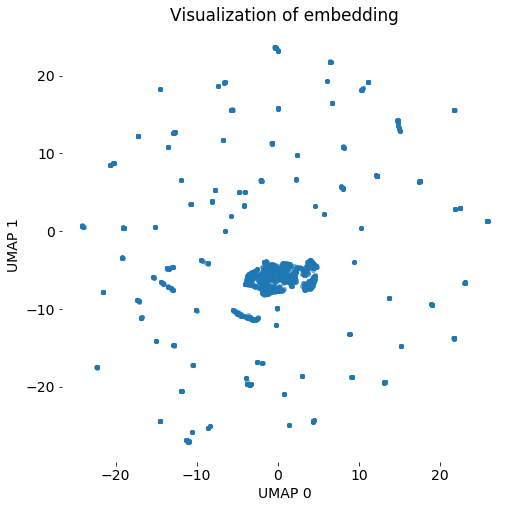

In [38]:
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(8, 8), frameon=False)
# for k in np.unique(labels):
#     plt.plot(z_tsne[labels==k, 0], 
#              z_tsne[labels==k, 1], '.', ms=8, alpha=0.5)
plt.plot(z_umap[:, 0], 
         z_umap[:, 1], '.', ms=8, alpha=0.5)

# lgnd = plt.legend(np.unique(labels).astype(int), 
#                   loc='center left', bbox_to_anchor=(1, 0.5))
# for i in range(len(lgnd.legendHandles)):
#     lgnd.legendHandles[i]._legmarker.set_markersize(20)
#     lgnd.legendHandles[i]._legmarker.set_alpha(1)

plt.xlabel('UMAP 0')
plt.ylabel('UMAP 1')
plt.title('Visualization of embedding')
plt.box(on=None)
plt.show()

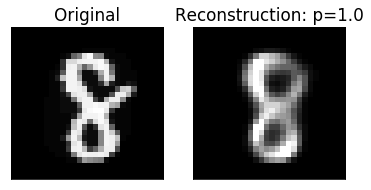

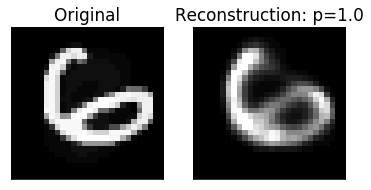

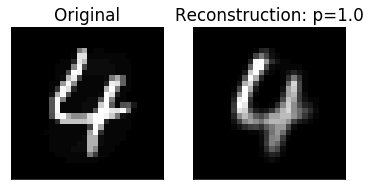

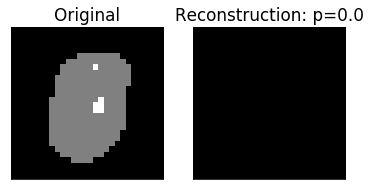

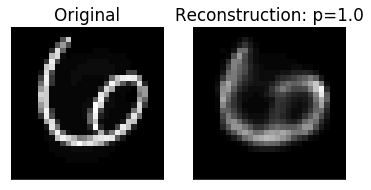

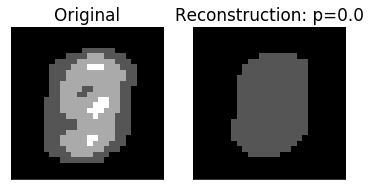

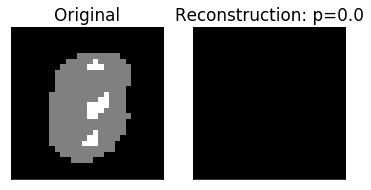

In [39]:
# image reconstruction

for d in range(data.shape[0]):
    plt.subplot(1, 2, 1)
    max_element = data[d, ...].max().item()
    plt.imshow(data[d, ...].reshape([28, 28]).numpy().squeeze(), cmap='gray',
               vmin=0, vmax=max_element)
    plt.xticks([])
    plt.yticks([])
    plt.title('Original')
    
    plt.subplot(1, 2, 2)
    embedding = denoiser.encoder(data[d, ...].to(device=denoiser.device))['loc']
    d_est = data[d, ...].sum(dim=-1) - (pyro.param("da_loc").detach() + 0.2**2/2).exp()
    reconstruction = (d_est*denoiser.decoder(embedding).detach()).round().cpu().reshape((28, 28)).numpy()

    embeddingP = denoiser.encoderP(data[d, ...].to(device=denoiser.device)).sigmoid().item()
    
    plt.imshow(reconstruction, cmap='gray',
               vmin=0, vmax=max_element)
    plt.xticks([])
    plt.yticks([])
#     plt.colorbar()
    plt.title(f'Reconstruction: p={embeddingP}')
    plt.show()
    if d > 5:
        break